<a href="https://colab.research.google.com/github/prathyusha1231/Basic-Calculator-using-Tkinter/blob/master/SARCASMDETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import nltk

Importing the Data

In [ ]:
data_1 = pd.read_json("Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data =  pd.concat([data_1, data_2])
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


Cleaning the data

In [ ]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

Tokenization and stopwords

In [ ]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["headline"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[:10]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way'],
 ['advancing', 'worlds', 'women'],
 ['fascinating', 'case', 'eating', 'labgrown', 'meat'],
 ['ceo', 'send', 'kids', 'school', 'work', 'company'],
 ['top', 'snake', 'handler', 'leaves', 'sinking', 'huckabee', 'campaign'],
 ['fridays', 'morning', 'email', 'inside', 'trumps', 'presser', 'ages']]

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Test - Train - Split

In [ ]:
validation_split = 0.25
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values
print(len(word_index))
indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]
print(word_index)

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  28657
vocab size - 28658
28657
{'new': 1, 'trump': 2, 'man': 3, 'us': 4, 'report': 5, 'one': 6, 'area': 7, 'woman': 8, 'donald': 9, 'says': 10, 'day': 11, 'time': 12, 'like': 13, 'first': 14, 'get': 15, 'trumps': 16, 'people': 17, 'house': 18, 'obama': 19, 'life': 20, 'still': 21, 'make': 22, 'white': 23, 'women': 24, 'back': 25, 'could': 26, 'would': 27, 'clinton': 28, 'years': 29, 'world': 30, 'family': 31, 'americans': 32, 'way': 33, 'study': 34, 'black': 35, 'gop': 36, 'bill': 37, 'really': 38, 'police': 39, 'best': 40, 'american': 41, 'school': 42, 'know': 43, 'finds': 44, 'watch': 45, 'show': 46, 'nation': 47, 'good': 48, 'president': 49, 'going': 50, 'home': 51, 'things': 52, 'death': 53, 'video': 54, 'say': 55, 'last': 56, 'state': 57, 'love': 58, 'big': 59, 'year': 60, 'every': 61, 'health': 62, 'parents': 63, 'campaign': 64, 'mom': 65, 'may': 66, 'hillary': 67, 'kids': 68, 'getting': 69, 'need': 70, 'gets': 71, 'party': 72, 'work': 73, 'little': 74, 'right': 

Test and train data

In [ ]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)
print(type(X_test_pad[0][0]))
print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (41496, 25)
Shape of y_train: (41496,)
<class 'numpy.int32'>
Shape of X_test_pad: (13832, 25)
Shape of y_test: (13832,)


Embedding layer

In [ ]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = '/content/'
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 829927 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim), dtype='float32')
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print(c)

24067
[[ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.44807  -0.018342 -0.31766  ... -0.12541   0.11663  -0.05747 ]
 [-0.24645   0.45248   0.8372   ... -0.98968  -0.25141  -0.54979 ]
 ...
 [ 0.        0.        0.       ...  0.        0.        0.      ]
 [ 0.18739  -0.38608  -0.034153 ...  0.34615  -1.0575    0.81905 ]
 [ 0.28769   0.76255  -0.84846  ... -0.24034   0.2967    1.0369  ]]


In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

Building the CNN-LSTM layer

In [ ]:
import tensorflow as tf
model = Sequential()

model.add(embedding_layer)

model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(64, dropout=0.75, recurrent_dropout=0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the model : ')
print(model.summary())

Summary of the built model...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           2865800   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 25, 32)            12832     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 12, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 2,903,529
Trainable params: 37,729
Non-trainable params: 2,865,800
_________________________________________________________________
None


Training the model

In [ ]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/6
1297/1297 - 26s - loss: 0.5679 - acc: 0.7040 - val_loss: 0.4964 - val_acc: 0.7611
Epoch 2/6
1297/1297 - 24s - loss: 0.5027 - acc: 0.7567 - val_loss: 0.4483 - val_acc: 0.7886
Epoch 3/6
1297/1297 - 23s - loss: 0.4672 - acc: 0.7816 - val_loss: 0.4201 - val_acc: 0.8036
Epoch 4/6
1297/1297 - 24s - loss: 0.4420 - acc: 0.7955 - val_loss: 0.4055 - val_acc: 0.8117
Epoch 5/6
1297/1297 - 23s - loss: 0.4268 - acc: 0.8043 - val_loss: 0.3907 - val_acc: 0.8242
Epoch 6/6
1297/1297 - 23s - loss: 0.4128 - acc: 0.8142 - val_loss: 0.3844 - val_acc: 0.8286


Vizualizing the layers

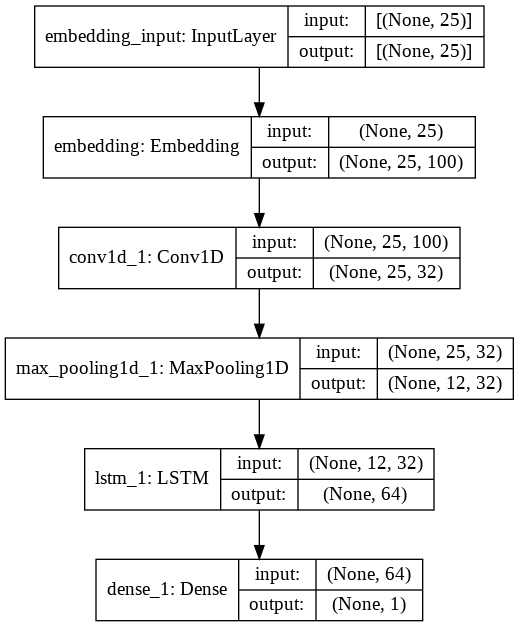

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Vizualizing the trained model

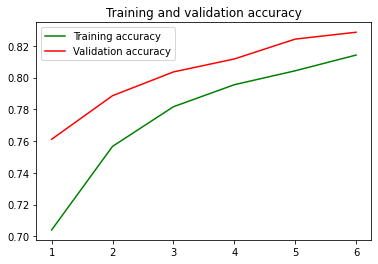

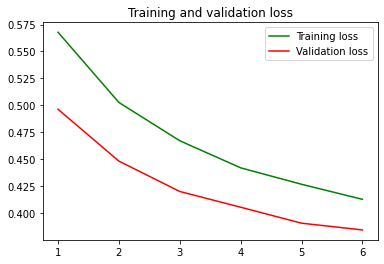

In [ ]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Predicting the model

In [ ]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's sarcasm!"
    else: return "It's not sarcasm."

In [ ]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's sarcasm!"

In [ ]:
predict_sarcasm("You just saved my dog's life. Thanks a million.")

"It's not sarcasm."

In [ ]:
predict_sarcasm("That's just what I needed today!")

"It's not sarcasm."

In [ ]:
predict_sarcasm("I'm glad we're having a rehearsal dinner. I rarely practice my meals before I eat")

"It's sarcasm!"

In [ ]:
predict_sarcasm("Ah, my birthday. Normally, I'd put on a festive hat and celebrate the fact that the Earth circled the Sun one more time. I really didn't think it was going to make it this year. But, darn it if it wasn't 'the little planet that could' all over again.")

"It's sarcasm!"

In [ ]:
predict_sarcasm("I want a million dollars!")

"It's not sarcasm."

In [ ]:
predict_sarcasm("Things return to normal.")

"It's not sarcasm."

In [ ]:
predict_sarcasm("I am busy right now, can I ignore you some other time?")

"It's sarcasm!"

In [ ]:
predict_sarcasm("Life’s good, You should get one.")

"It's not sarcasm."

In [ ]:
predict_sarcasm("Ayaan is not a nerd, he scores full marks.")

"It's sarcasm!"

In [ ]:
predict_sarcasm("He is going to school.")

"It's not sarcasm."

In [ ]:
predict_sarcasm("Was he a good scientist?")

"It's not sarcasm."

In [ ]:
predict_sarcasm("Hello. How are you?")

"It's not sarcasm."

In [ ]:
predict_sarcasm("It's bright and sunny outside.")

"It's not sarcasm."

In [ ]:
predict_sarcasm("Life is hard.")

"It's not sarcasm."

In [ ]:
predict_sarcasm("Yeah sure, that's totally going to work.")

"It's sarcasm!"

In [ ]:
predict_sarcasm("Oh no no, I slept a lot yesterday.")

"It's sarcasm!"

Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges):
    
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Train accuracy: 0.8609263543474069
Test accuracy 0.8285858877964141
[[19201  3296]
 [ 2475 16524]]
[[6123 1350]
 [1021 5338]]


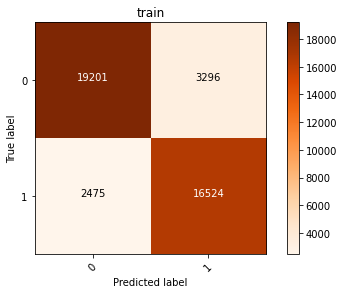

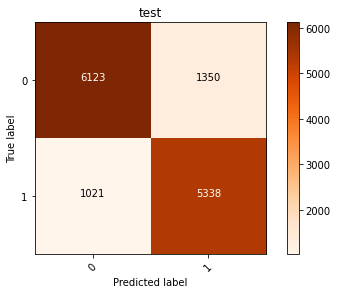

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools

predictions_nn_train = model.predict(X_train_pad)
predictions_nn_test = model.predict(X_test_pad)
for i in range(len(predictions_nn_train)):
    if predictions_nn_train[i][0] < 0.5:
        predictions_nn_train[i][0] = 0
    else:
        predictions_nn_train[i][0] = 1
        
for i in range(len(predictions_nn_test)):
    if predictions_nn_test[i][0] < 0.5:
        predictions_nn_test[i][0] = 0
    else:
        predictions_nn_test[i][0] = 1


print('Train accuracy:', accuracy_score(y_train, predictions_nn_train))
print('Test accuracy', accuracy_score(y_test, predictions_nn_test))


cnf_matrix_train = confusion_matrix(y_train, predictions_nn_train)
cnf_matrix_test = confusion_matrix(y_test, predictions_nn_test)
plt.figure()
plot_confusion_matrix(cnf_matrix_train,
                      classes=[0,1],
                      title='train')
plt.figure()
plot_confusion_matrix(cnf_matrix_test,
                      classes=[0,1],
                      title='test')
